### Coursera IBM Data Science Professional Certificate
### Author: Alina Prendes Roque
#### This is the final assignment of the Applied Data Science Capstone Project

#### 1. Install the required libraries

In [1]:
!pip install geocoder
!pip install folium
!pip install geopy
!pip install pywaffle


#### 2. Import the required libraries

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import geocoder
from urllib.request import urlopen
from urllib.error import HTTPError
from urllib.error import URLError
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize 
import json
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import time
from pywaffle import Waffle
import seaborn as sns
print("Setup completed")

Setup completed


#### 3. Scrape the data from the website

In [3]:
link="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V"
raw_data= requests.get(link).text
soup = BeautifulSoup(raw_data,'xml')

#### 4. Transform the extracted data into a dataframe

In [4]:
table = soup.find("table")
fields = table.find_all("td")

Postal_Code = []
Borough = []
Neighborhood = []

for i in range(0, len(fields)):
    Information=list()
    Postal_Code.append(fields[i].b.text)
    try:
        Borough.append(fields[i].a.text)
        l=len(fields[i].a.text)
        Information = fields[i].span.text
        Neighborhood.append(Information[l:])
    except:
        Borough.append("Not assigned")
        Neighborhood.append("Not assigned")
df = pd.DataFrame(data=[Postal_Code, Borough, Neighborhood]).transpose()
df.columns = ["Postal Code", "Borough", "Neighborhood"]
df=df.sort_values(by="Postal Code")
print(df.shape)
df.head(5)

(180, 3)


,Postal Code,Borough,Neighborhood
0,V1A,Kimberley,
9,V1B,Vernon,East
18,V1C,Cranbrook,
27,V1E,Salmon Arm,
36,V1G,Dawson Creek,


#### 5. Delete the rows where the Borough is not assigned
##### Note: in this case, 5 rows were deleted, which is the same amount of postal codes that have no borough assigned on the website

In [5]:
df["Borough"].replace("Not assigned", np.nan, inplace=True)
df.dropna(subset=["Borough"], inplace=True)
print(df.shape)

(175, 3)


#### 6. Handle strings to format the neighborhood column so that it can easily be read

In [6]:
df["Neighborhood"] = df["Neighborhood"].str.replace(" /",",", regex=True)
df["Neighborhood"] = df["Neighborhood"].str.replace("(","",regex=True)
df["Neighborhood"] = df["Neighborhood"].str.replace(")","",regex=True)

#### 7. Extra step, print the first 10 rows to make sure that the output is correct
##### Note: this is another sanity-check step, just to make sure that the obtained data is accurate

In [7]:
df.head(10)

,Postal Code,Borough,Neighborhood
0,V1A,Kimberley,
9,V1B,Vernon,East
18,V1C,Cranbrook,
27,V1E,Salmon Arm,
36,V1G,Dawson Creek,
45,V1H,Vernon,West
54,V1J,Fort St. John,
63,V1K,Merritt,
72,V1L,Nelson,
81,V1M,Langley Township,North


#### 8. Select the relevant boroughs (those who include Vancouver)

In [8]:
df_Vancouver = df[df["Borough"].str.contains("Vancouver")]
df_Vancouver.shape

(44, 3)

#### 9. Describe the obtained dataframe
##### Note: the obtained dataframe has 44 rows, i.e., further analysis will not be carried out to the 175 boroughs (which correspond to the whole Biritish Columbia), but to the 44 that correspond to Vancouver

In [9]:
df_Vancouver.describe()

,Postal Code,Borough,Neighborhood
count,44,44,44
unique,44,4,44
top,V7S,Vancouver,North Grandview-Woodland
freq,1,31,1


#### 10. Create a function to obtain coordinates for each postal code

In [10]:
def get_location_by_postal_code(postal_code):
    """This function returns a location from a provided postal code
    """
    time.sleep(1)
    try:
        g = geocoder.arcgis(postal_code)
        Latitude = g.latlng[0]
        Longitude = g.latlng[1]
    except:
        Latitude = "Not found"
        Longitude = "Not found"
    return postal_code, Latitude, Longitude

#### 11. Apply the function to each postal code of the initially created dataframe and transform the result into a new dataframe

In [11]:
Postal_Code_Coordinates = []
Latitude = []
Longitude = []

postal_codes=df_Vancouver["Postal Code"]
for postal_code in postal_codes.tolist():
    Postal_Code_Coordinates.append(get_location_by_postal_code(postal_code)[0])
    Latitude.append(get_location_by_postal_code(postal_code)[1])
    Longitude.append(get_location_by_postal_code(postal_code)[2])

df_Coordinates = pd.DataFrame(data=[Postal_Code_Coordinates, Latitude, Longitude]).transpose()
df_Coordinates.columns = ["Postal Code", "Latitude", "Longitude"]
df_Coordinates=df_Coordinates.sort_values(by="Postal Code")
print(df_Coordinates.shape)


(44, 3)


#### 12. Delete any postal code for which either longitude or latitude was not found

In [12]:
length_before=len(df_Coordinates.index)
df_Coordinates["Latitude"].replace("Not found", np.nan, inplace=True)
df_Coordinates.dropna(subset=["Latitude"], inplace=True)
df_Coordinates["Longitude"].replace("Not found", np.nan, inplace=True)
df_Coordinates.dropna(subset=["Longitude"], inplace=True)
length_after=len(df_Coordinates.index)
if length_after-length_before == 0: 
    print ("No postal code was deleted because of missing coordinates")
elif length_after-length_before == 1: 
    print("1 postal code was deleted because of missing coordinates")
else:
    print(length_after-length_before, "postal codes was/were deleted because of missing coordinates")

No postal code was deleted because of missing coordinates


#### 13. Merge the two created dataframes
##### Note: the result will be a complete dataframe that contains all the relevant postal codes with its borough, neighborhoods, latitude and longitude

In [13]:
df_complete = pd.merge(df_Vancouver, df_Coordinates, on="Postal Code")
df_complete.columns = ["Postal Code", "Borough", "Neighborhood","Latitude","Longitude"]
print(df_complete.shape)
df_complete.head()

(44, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,V5K,Vancouver,North Hastings-Sunrise,49.28167,-123.03998
1,V5L,Vancouver,North Grandview-Woodland,49.2807,-123.06684
2,V5M,Vancouver,"South Hastings-Sunrise, North Renfrew-Collingwood",49.26043,-123.04009
3,V5N,Vancouver,"South Grandview-Woodland, NE Kensington-Cedar ...",49.25442,-123.0668
4,V5P,Vancouver,"SE Kensington-Cedar Cottage, Victoria-Fraserview",49.22293,-123.06688


#### 14. Extra step: export the dataframe into excel
##### Note: this step is completely optional, but can be recommendable to check the obtained information

In [14]:
writer = pd.ExcelWriter("df_complete.xlsx")
df_complete.to_excel(writer)
writer.save()
print("df_complete Dataframe was successfully exported into an Excel file.")

df_complete Dataframe was successfully exported into an Excel file.


#### 15. Visualize the information in a map

In [15]:
Address = 'Vancouver'
Geolocator = Nominatim(user_agent="aprendesr@yahoo.es")
Location = Geolocator.geocode(Address)
Latitude = Location.latitude
Longitude = Location.longitude
print("The geograpical coordinates of Vancouver are {}, {}.".format(Latitude, Longitude))

The geograpical coordinates of Vancouver are 49.2608724, -123.1139529.


In [16]:
map_Vancouver = folium.Map(location=[Latitude, Longitude], zoom_start=11)
for lat, lng, borough, neighborhood in zip(df_complete["Latitude"], df_complete["Longitude"], df_complete["Borough"], df_complete["Neighborhood"]):
    label = "{}, {}".format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color="#232066",
        fill=True,
        fill_color="#232066",
        fill_opacity=100).add_to(map_Vancouver)  
map_Vancouver

#### 16. Import data from Foursquare
##### Note: for more security, Client ID and Client Secret fields will be asked via input, so that the information is not shown explicitly

In [17]:
Client_ID=input("Please enter your Client ID:")
Client_Secret=input("Please enter your Client Secret:")
Version="20180602"
Radius=500
Limit=100

#### 17. Create a function to obtain vanues for each neighborhood

In [18]:
def get_nearby_venues(neighborhoods, latitudes, longitudes):
    """This function returns a dataframe with the nearby venues of a list of locations
    """
    venues=[]
    for neighborhood, latitude, longitude in zip(neighborhoods, latitudes, longitudes):
        request="https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radious={}&limit={}".format(
            Client_ID,
            Client_Secret,
            Version,
            latitude,
            longitude,
            Radius,
            Limit)
        
        results=requests.get(request).json()["response"]["groups"][0]["items"]

        for result in results:
            venues.append([(
                neighborhood,
                latitude,
                longitude,
                result["venue"]["name"],
                result["venue"]["location"]["lat"],
                result["venue"]["location"]["lng"],
                result["venue"]["categories"][0]["name"])])
    df_venues=pd.DataFrame([venue for venues in venues for venue in venues])
    df_venues.columns=["Neighborhood", "Latitude", "Longitude", "Venue_Name", "Venue_Latitude", "Venue_Longitude", "Venue_Category"]
    return (df_venues.shape, df_venues)



#### 18. Apply the function to each neighborhood and transform the results into a new dataframe

In [19]:
df_venues=get_nearby_venues(neighborhoods=df_complete["Neighborhood"],latitudes=df_complete["Latitude"],longitudes=df_complete["Longitude"])[1]

#### 19. Check the number of venues and show the first lines of the created dataframe

In [20]:
print(df_venues.shape)
df_venues.head()

(4379, 7)


,Neighborhood,Latitude,Longitude,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Category
0,North Hastings-Sunrise,49.28167,-123.03998,The Fair at the PNE,49.282971,-123.042109,Fair
1,North Hastings-Sunrise,49.28167,-123.03998,Tamam Fine Palestinian Cuisine,49.281070,-123.051438,Middle Eastern Restaurant
2,North Hastings-Sunrise,49.28167,-123.03998,Wooden Roller Coaster,49.281744,-123.035128,Theme Park Ride / Attraction
3,North Hastings-Sunrise,49.28167,-123.03998,New Brighton Park,49.289614,-123.038484,Park
4,North Hastings-Sunrise,49.28167,-123.03998,Livestock Barns,49.284037,-123.039278,Farm


#### 20. Check how many venues were obtained per neighborhood

In [21]:
df_venues.groupby(["Neighborhood"]).count()

,Latitude,Longitude,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Category
Neighborhood,,,,,,
Bentall Centre,100,100,100,100,100,100
"Central Kitsilano, Greektown",100,100,100,100,100,100
East Central,100,100,100,100,100,100
"East Fairview, South Cambie",100,100,100,100,100,100
East Mount Pleasant,100,100,100,100,100,100
Inner East,100,100,100,100,100,100
Killarney,100,100,100,100,100,100
"NE Downtown, Gastown, Harbour Centre, International Village, Victory Square, Yaletown",89,89,89,89,89,89
"NW Arbutus Ridge, NE Dunbar-Southlands",100,100,100,100,100,100


#### 21. Determine how many different venues categories were obtained, and show them
##### Note: this is important, as here the user can determine which categories are relevant

In [22]:
print(len(df_venues["Venue_Category"].unique()))
print("Shopping Mall" in df_venues["Venue_Category"].unique())
df_venues["Venue_Category"].unique()

237
True


array(['Fair', 'Middle Eastern Restaurant',
       'Theme Park Ride / Attraction', 'Park', 'Farm', 'Hockey Arena',
       'Mexican Restaurant', 'Grocery Store', 'Vietnamese Restaurant',
       'Coffee Shop', 'Café', 'Theme Park', 'Hot Dog Joint',
       'Indian Restaurant', 'Breakfast Spot', 'Brewery', 'Food Truck',
       'Malay Restaurant', 'Dessert Shop', 'Bakery', 'Sushi Restaurant',
       'Racetrack', 'Pizza Place', 'Southern / Soul Food Restaurant',
       'French Restaurant', 'Hobby Shop', 'Fried Chicken Joint',
       'Motorcycle Shop', 'Theater', 'Deli / Bodega', 'Tapas Restaurant',
       'Thai Restaurant', 'Liquor Store', 'Italian Restaurant',
       'Gourmet Shop', 'Cuban Restaurant', 'Cajun / Creole Restaurant',
       'Sandwich Place', 'Scandinavian Restaurant',
       'Latin American Restaurant', 'Ice Cream Shop',
       'Athletics & Sports', 'Japanese Restaurant', 'Noodle House', 'Gym',
       'Greek Restaurant', 'Vegetarian / Vegan Restaurant', 'Nightclub',
       'Di

#### 22. Analyze each neighborhood independently

In [23]:
Vancouver_onehot=pd.get_dummies(df_venues[["Venue_Category"]],prefix="",prefix_sep="")
Vancouver_onehot["Neighborhood"]=df_venues["Neighborhood"]
First_Column=[Vancouver_onehot.columns[-1]] + list(Vancouver_onehot.columns[:-1])
Vancouver_onehot=Vancouver_onehot[First_Column]
print(Vancouver_onehot.shape)
Vancouver_onehot.head()

(4379, 238)


,Neighborhood,Accessories Store,Airport Lounge,Airport Service,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Game Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Waterfall,Waterfront,Wine Shop,Women's Store,Yoga Studio
0,North Hastings-Sunrise,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,North Hastings-Sunrise,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,North Hastings-Sunrise,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,North Hastings-Sunrise,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,North Hastings-Sunrise,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 23. Group information by neighborhood, taking the mean of the frequency for each category

In [24]:
Vancouver_grouped=Vancouver_onehot.groupby(["Neighborhood"]).mean().reset_index()
print(Vancouver_grouped.shape)
Vancouver_grouped.head()

(44, 238)


,Neighborhood,Accessories Store,Airport Lounge,Airport Service,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Game Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Waterfall,Waterfront,Wine Shop,Women's Store,Yoga Studio
0,Bentall Centre,0.0,0.0,0.0,0.04,0.0,0.01,0.00,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.01,0.00,0.00,0.02
1,"Central Kitsilano, Greektown",0.0,0.0,0.0,0.01,0.0,0.00,0.00,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.04
2,East Central,0.0,0.0,0.0,0.00,0.0,0.01,0.00,0.01,0.0,...,0.0,0.00,0.0,0.0,0.0,0.01,0.00,0.01,0.00,0.01
3,"East Fairview, South Cambie",0.0,0.0,0.0,0.00,0.0,0.00,0.01,0.00,0.0,...,0.0,0.05,0.0,0.0,0.0,0.00,0.00,0.00,0.01,0.00
4,East Mount Pleasant,0.0,0.0,0.0,0.00,0.0,0.00,0.02,0.00,0.0,...,0.0,0.04,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.02


#### 24. Describe the obtained dataframe
##### Note: the obtained dataframe has as expected 44 rows (total number of analyzed boroughs) and 237 columns (total number of venues obtained from Foursquare API)

In [25]:
Vancouver_grouped.describe()

,Accessories Store,Airport Lounge,Airport Service,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Video Game Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Waterfall,Waterfront,Wine Shop,Women's Store,Yoga Studio
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,...,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0.000455,0.000227,0.000455,0.010495,0.000682,0.002524,0.001619,0.007751,0.000455,0.000455,...,0.000455,0.023693,0.000227,0.000710,0.001591,0.000909,0.001591,0.001364,0.001364,0.011160
std,0.002107,0.001508,0.002107,0.009139,0.002550,0.004423,0.004343,0.011791,0.002107,0.002107,...,0.002107,0.033759,0.001508,0.002659,0.003700,0.002908,0.004283,0.003471,0.003471,0.012428
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
75%,0.000000,0.000000,0.000000,0.020000,0.000000,0.002500,0.000000,0.010000,0.000000,0.000000,...,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000
max,0.010000,0.010000,0.010000,0.040000,0.010000,0.010526,0.020000,0.050000,0.010000,0.010000,...,0.010000,0.130000,0.010000,0.011236,0.010000,0.010000,0.020000,0.010000,0.010000,0.040000


#### 25. Select the relevant criteria (categories) that want to be taken into account for comparing neighborhoods
##### Note: these criteria are determined by the analyst/ user. In this case, it is considered important to further analyze the neighborhoods in terms of Hotels, Vegeratian / Vegan Restaurants, Coffee Shops and Gym / Fitness Centers (the same analysis can be carried out with any other categories)

In [26]:
print(len(Vancouver_grouped[Vancouver_grouped["Hotel"]>0]), len(Vancouver_grouped[Vancouver_grouped["Vegetarian / Vegan Restaurant"]>0]), len(Vancouver_grouped[Vancouver_grouped["Coffee Shop"]>0]), len(Vancouver_grouped[Vancouver_grouped["Gym / Fitness Center"]>0]))
Vancouver_grouped__relevant=Vancouver_grouped[["Neighborhood","Hotel","Vegetarian / Vegan Restaurant","Coffee Shop", "Gym / Fitness Center"]]
Vancouver_grouped__relevant

20 33 44 14


,Neighborhood,Hotel,Vegetarian / Vegan Restaurant,Coffee Shop,Gym / Fitness Center
0,Bentall Centre,0.110000,0.000000,0.030000,0.00
1,"Central Kitsilano, Greektown",0.000000,0.020000,0.080000,0.00
2,East Central,0.010000,0.020000,0.050000,0.00
3,"East Fairview, South Cambie",0.000000,0.020000,0.070000,0.01
4,East Mount Pleasant,0.000000,0.000000,0.080000,0.00
5,Inner East,0.000000,0.010000,0.050000,0.00
6,Killarney,0.020000,0.010000,0.050000,0.01
7,"NE Downtown, Gastown, Harbour Centre, Internat...",0.067416,0.022472,0.078652,0.00
8,"NW Arbutus Ridge, NE Dunbar-Southlands",0.000000,0.020000,0.070000,0.00
9,"NW Dunbar-Southlands, Chaldecutt, South Univer...",0.000000,0.030000,0.090000,0.00


#### 26. Determine the optimal k-value

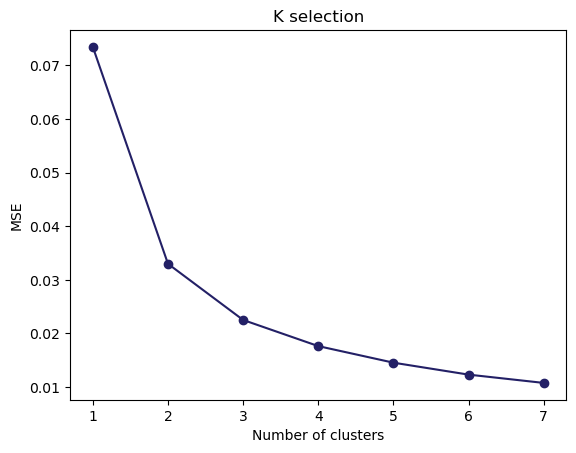

In [27]:
plt.style.use("default")
Ks=8
mse=np.zeros(Ks-1)
Vancouver_grouped_clustering=Vancouver_grouped__relevant.drop(["Neighborhood"],1)
for n in range(1,Ks):
    k_clusters=n
    kmeans=KMeans(n_clusters=k_clusters,random_state=0, init="random", n_init=15).fit(Vancouver_grouped_clustering)
    mse[n-1]=kmeans.inertia_

plt.plot(range(1,Ks),mse,marker="o",color="#232066")
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

#### 27. Run k-means clustering and add the clustering labels to the dataframe
##### Note: according to the elbow method, 3 clusters will be created

In [28]:
n_clusters=3
kmeans=KMeans(n_clusters=n_clusters,random_state=0,init="random",n_init=15).fit(Vancouver_grouped_clustering)
df_complete["Cluster"]=kmeans.labels_
df_complete

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster
0,V5K,Vancouver,North Hastings-Sunrise,49.28167,-123.03998,1
1,V5L,Vancouver,North Grandview-Woodland,49.2807,-123.06684,2
2,V5M,Vancouver,"South Hastings-Sunrise, North Renfrew-Collingwood",49.26043,-123.04009,0
3,V5N,Vancouver,"South Grandview-Woodland, NE Kensington-Cedar ...",49.25442,-123.0668,2
4,V5P,Vancouver,"SE Kensington-Cedar Cottage, Victoria-Fraserview",49.22293,-123.06688,2
5,V5R,Vancouver,South Renfrew-Collingwood,49.23996,-123.04113,0
6,V5S,Vancouver,Killarney,49.21537,-123.04112,0
7,V5T,Vancouver,East Mount Pleasant,49.26297,-123.09165,1
8,V5V,Vancouver,"West Kensington-Cedar Cottage, NE Riley Park-L...",49.24843,-123.09056,2
9,V5W,Vancouver,"SE Riley Park-Little Mountain, SW Kensington-C...",49.23201,-123.09139,2


#### 28. Extra step: merge all the information into one dataframe
##### Note: this step is optional, but allows to analyse possible similarities or patterns in the different clusters

In [29]:
df_complete_relevant=Vancouver_grouped__relevant.join(df_complete.set_index("Neighborhood"),on="Neighborhood")
df_complete_relevant.sort_values(["Cluster"], inplace=True)
print(df_complete_relevant.shape)
df_complete_relevant

(44, 10)


,Neighborhood,Hotel,Vegetarian / Vegan Restaurant,Coffee Shop,Gym / Fitness Center,Postal Code,Borough,Latitude,Longitude,Cluster
1,"Central Kitsilano, Greektown",0.000000,0.020000,0.080000,0.00,V6K,Vancouver,49.2676,-123.16528,0
2,East Central,0.010000,0.020000,0.050000,0.00,V7J,North Vancouver (district municipality),49.32384,-123.04236,0
3,"East Fairview, South Cambie",0.000000,0.020000,0.070000,0.01,V5Z,Vancouver,49.247,-123.12051,0
41,"West Kerrisdale, South Dunbar-Southlands, Musq...",0.000000,0.020000,0.080000,0.00,V6N,Vancouver,49.23257,-123.18841,0
5,Inner East,0.000000,0.010000,0.050000,0.00,V7H,North Vancouver (district municipality),49.31647,-122.99008,0
6,Killarney,0.020000,0.010000,0.050000,0.01,V5S,Vancouver,49.21537,-123.04112,0
39,"West Fairview, Granville Island, NE Shaughnessy",0.010000,0.010000,0.060000,0.01,V6H,Vancouver,49.25444,-123.13172,0
32,Southeast,0.010000,0.000000,0.070000,0.00,V7T,West Vancouver,49.33205,-123.13758,0
31,"South Shaughnessy, NW Oakridge, NE Kerrisdale,...",0.000000,0.000000,0.040000,0.01,V6M,Vancouver,49.2344,-123.1454,0
30,South Renfrew-Collingwood,0.020000,0.040000,0.050000,0.02,V5R,Vancouver,49.23996,-123.04113,0


#### 29. Create a map and visualize the clusters

In [30]:
Map_clusters=folium.Map(location=[Latitude,Longitude],zoom_start=11)
x=np.arange(n_clusters)
y=[i+x+(i*x)**2 for i in range(n_clusters)]
colors_array=("#983D3D", "#232066", "#DCB732"),
markers_colors=[]
for lat, lng, neighborhood, cluster in zip(df_complete_relevant["Latitude"], df_complete_relevant["Longitude"], df_complete_relevant["Neighborhood"], df_complete_relevant["Cluster"]):
    label=str(neighborhood)+ " Cluster " + str(cluster)
    label=folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=4,
        popup=label,
        color=colors_array[0][cluster],
        fill=True,
        fill_color=colors_array[0][cluster],
        fill_opacity=100).add_to(Map_clusters)
Map_clusters

#### 30. Extra step: export the map as an html file
##### Note: this step is completely optional, but can be recommendable to store the obtained results

In [31]:
Map_clusters.save("Map_clusters.html")

#### 31. Description of the clusters, the number of neighborhoods and the average venue value per cluster

In [32]:
cluster_0=df_complete_relevant.loc[df_complete_relevant["Cluster"]==0]
cluster_1=df_complete_relevant.loc[df_complete_relevant["Cluster"]==1]
cluster_2=df_complete_relevant.loc[df_complete_relevant["Cluster"]==2]
print(cluster_0.shape,cluster_1.shape,cluster_2.shape)
df_description=df_complete_relevant.groupby("Cluster")[["Hotel","Vegetarian / Vegan Restaurant","Coffee Shop","Gym / Fitness Center"]].mean()
df_description

(14, 10) (7, 10) (23, 10)


,Hotel,Vegetarian / Vegan Restaurant,Coffee Shop,Gym / Fitness Center
Cluster,,,,
0,0.019286,0.015000,0.060000,0.006429
1,0.002857,0.012857,0.076090,0.002857
2,0.019476,0.019696,0.064472,0.004348


#### 32. Visualize the cluster's distribution via a waffle chart
##### Note: even if this chart shows the relative density of the clusters, it is necesary to further determine the differences among each cluster, which is why boxplots are build

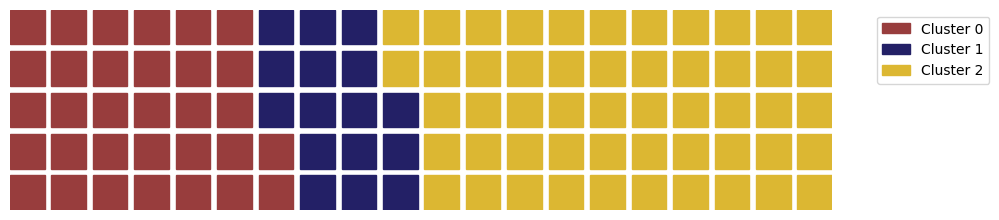

In [33]:
Values=[cluster_0.shape[0]*100/df_complete_relevant.shape[0],cluster_1.shape[0]*100/df_complete_relevant.shape[0],cluster_2.shape[0]*100/df_complete_relevant.shape[0]]
Labels=["Cluster 0","Cluster 1", "Cluster 2"]
Waffle_Chart = plt.figure(
    FigureClass=Waffle, 
    rows=5, 
    values=Values,
    labels=Labels,
    colors=("#983D3D", "#232066", "#DCB732"),
    figsize=(10, 10),
    legend={'bbox_to_anchor': (1.2, 1)})

#### 33. Compare cluster's structure via boxplots
##### Note: via these boxplots it is possible to see what differentiates each cluster and to have a better idea of which cluster contains the neighborhoods with the highest average presence of each venue's category

<AxesSubplot:xlabel='Cluster', ylabel='Gym / Fitness Center'>

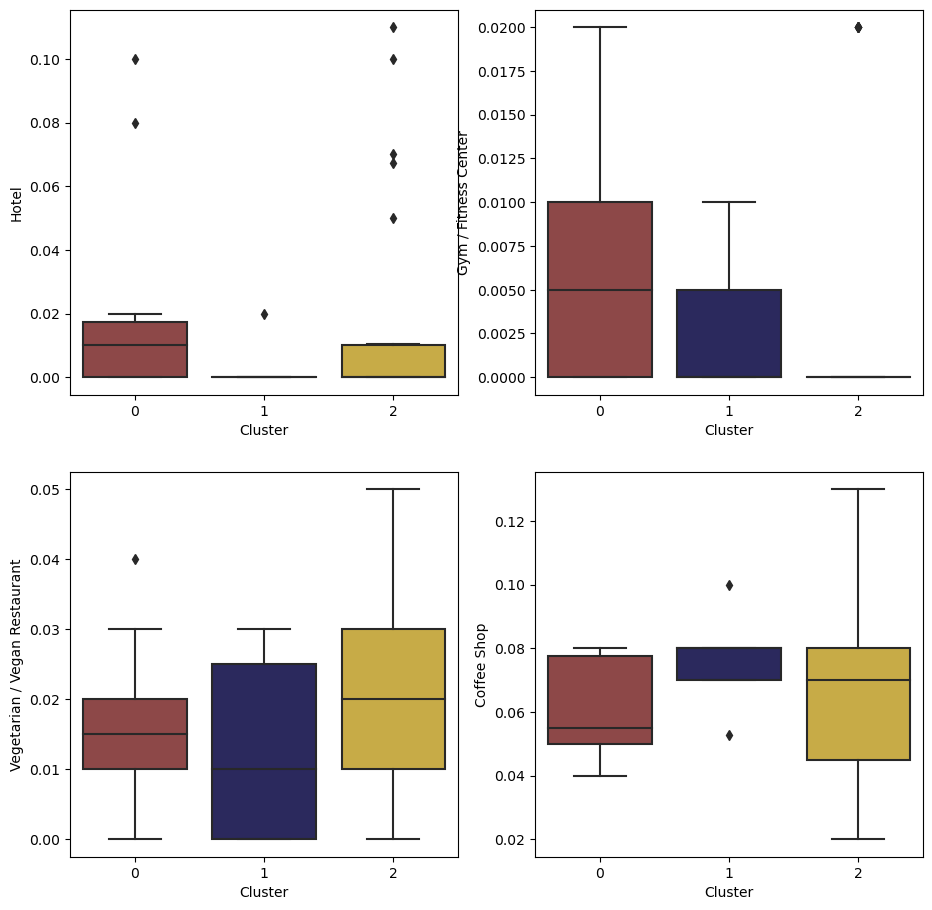

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(11, 11))
colors_array=("#983D3D", "#232066", "#DCB732")
sns.boxplot(x=df_complete_relevant["Cluster"], y=df_complete_relevant["Hotel"], ax=axs[0,0], palette=colors_array)
sns.boxplot(x=df_complete_relevant["Cluster"], y=df_complete_relevant["Vegetarian / Vegan Restaurant"], ax=axs[1,0], palette=colors_array)
sns.boxplot(x=df_complete_relevant["Cluster"], y=df_complete_relevant["Coffee Shop"], ax=axs[1,1], palette=colors_array)
sns.boxplot(x=df_complete_relevant["Cluster"], y=df_complete_relevant["Gym / Fitness Center"], ax=axs[0,1], palette=colors_array)

#### Please note that this project is complemented by a final report that contains a detailed explanation of the analysis that were made 
#### I hope this was helpful and enjoyable. If you have any question and/or suggestion, please do not hesitate to contact me via Linkedin: https://www.linkedin.com/in/alinaprendesroque/